In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import files
uploaded = files.upload()

Saving prices.csv to prices.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving securities.csv to securities.csv


In [15]:
df = pd.read_csv("prices.csv")
comp_info = pd.read_csv("securities.csv")

In [16]:
print("Prices shape:", df.shape)
print("Securities shape:", comp_info.shape)
df.head()


Prices shape: (851264, 7)
Securities shape: (505, 8)


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [17]:
print("Unique companies:", df['symbol'].nunique())

Unique companies: 501


In [18]:
df['symbol'].value_counts().head(10)

,count
symbol,
AIV,1762
ZION,1762
ZBH,1762
YUM,1762
AMGN,1762
AMG,1762
AME,1762
AMAT,1762
ALXN,1762


In [19]:
comp_info[comp_info['Security'].str.contains('Yahoo', case=False)]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
500,YHOO,Yahoo Inc.,reports,Information Technology,Internet Software & Services,"Sunnyvale, California",NaN,1011006


In [20]:
selected_companies = ['YHOO', 'MSFT', 'GOOG', 'AAPL', 'FB']

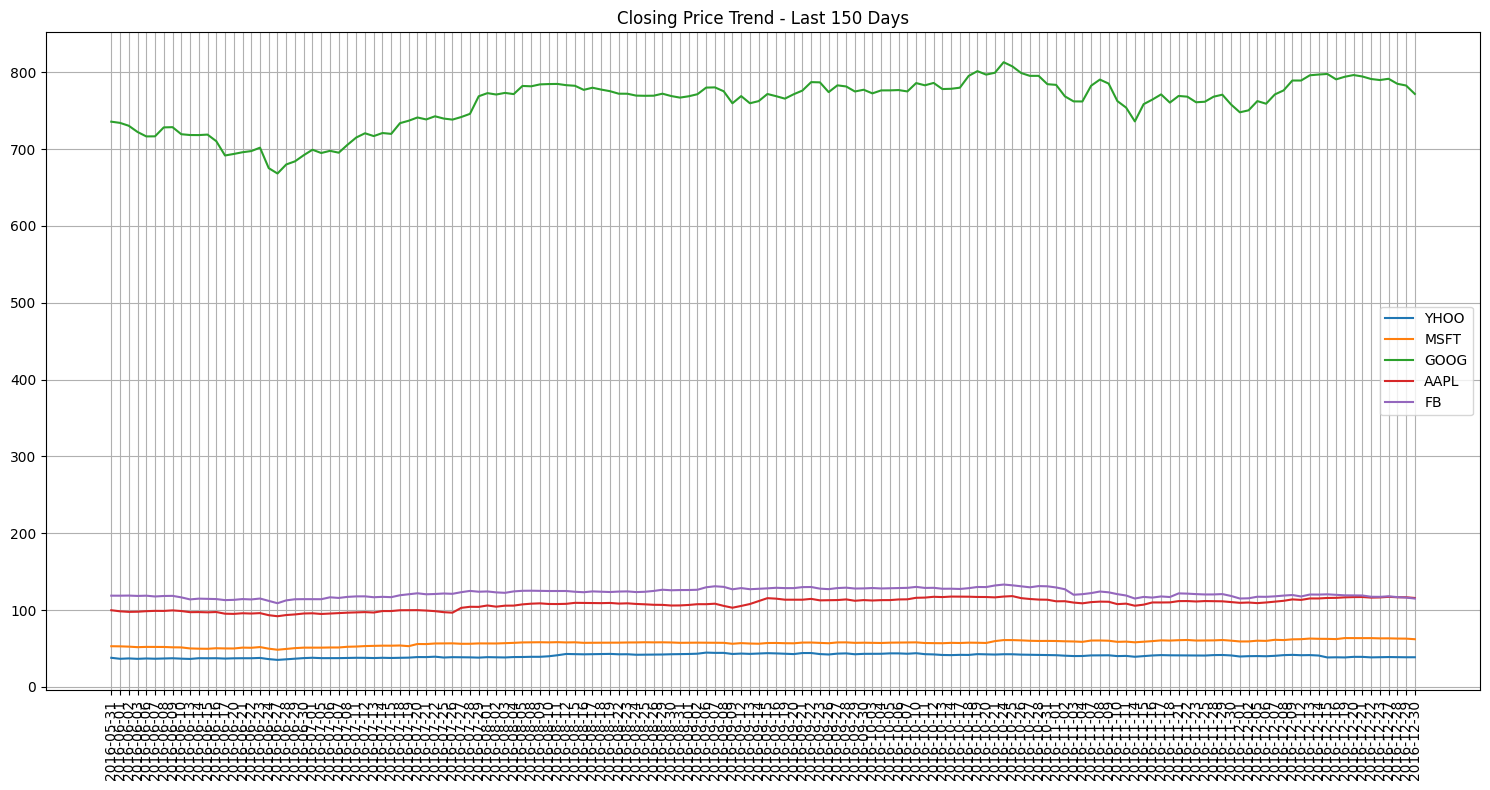

In [21]:
plt.figure(figsize=(15,8))
for symbol in selected_companies:
    company = df[df['symbol'] == symbol].sort_values('date')
    plt.plot(company['date'].values[-150:], company['close'].values[-150:], label=symbol)
plt.xticks(rotation=90)
plt.title("Closing Price Trend - Last 150 Days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

In [23]:
results = {}

In [24]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i, 3])
    return np.array(X), np.array(y)

In [25]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [39]:
for symbol in selected_companies:
    print(f"\n📊 Processing {symbol}")

    df_sym = df[df['symbol'] == symbol].sort_values('date').reset_index(drop=True)

    if df_sym.shape[0] < 50:
        print(f"⚠️ Not enough data for {symbol}. Skipping.")
        continue

    data = df_sym[['open', 'high', 'low', 'close', 'volume']].values
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    time_step = 30
    X, y = create_dataset(scaled_data, time_step)

    if len(X) < 10:
        print(f"⚠️ Not enough sequences for {symbol}. Skipping.")
        continue

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_model((X_train.shape[1], X_train.shape[2]))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=50,
              batch_size=64,
              callbacks=[early_stop],
              verbose=0)

    y_pred = model.predict(X_test)

    close_scaler = MinMaxScaler()
    close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
    y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = close_scaler.inverse_transform(y_pred)

    results[symbol] = {
        "actual": y_test_inv.flatten(),
        "predicted": y_pred_inv.flatten(),
        "r2": r2_score(y_test_inv, y_pred_inv)
    }

    print(f"✅ {symbol} R² Score: {results[symbol]['r2']:.4f}")



📊 Processing YHOO


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
✅ YHOO R² Score: 0.9203

📊 Processing MSFT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
✅ MSFT R² Score: 0.6396

📊 Processing GOOG


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
✅ GOOG R² Score: 0.8741

📊 Processing AAPL


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
✅ AAPL R² Score: 0.7993

📊 Processing FB


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
✅ FB R² Score: 0.7199


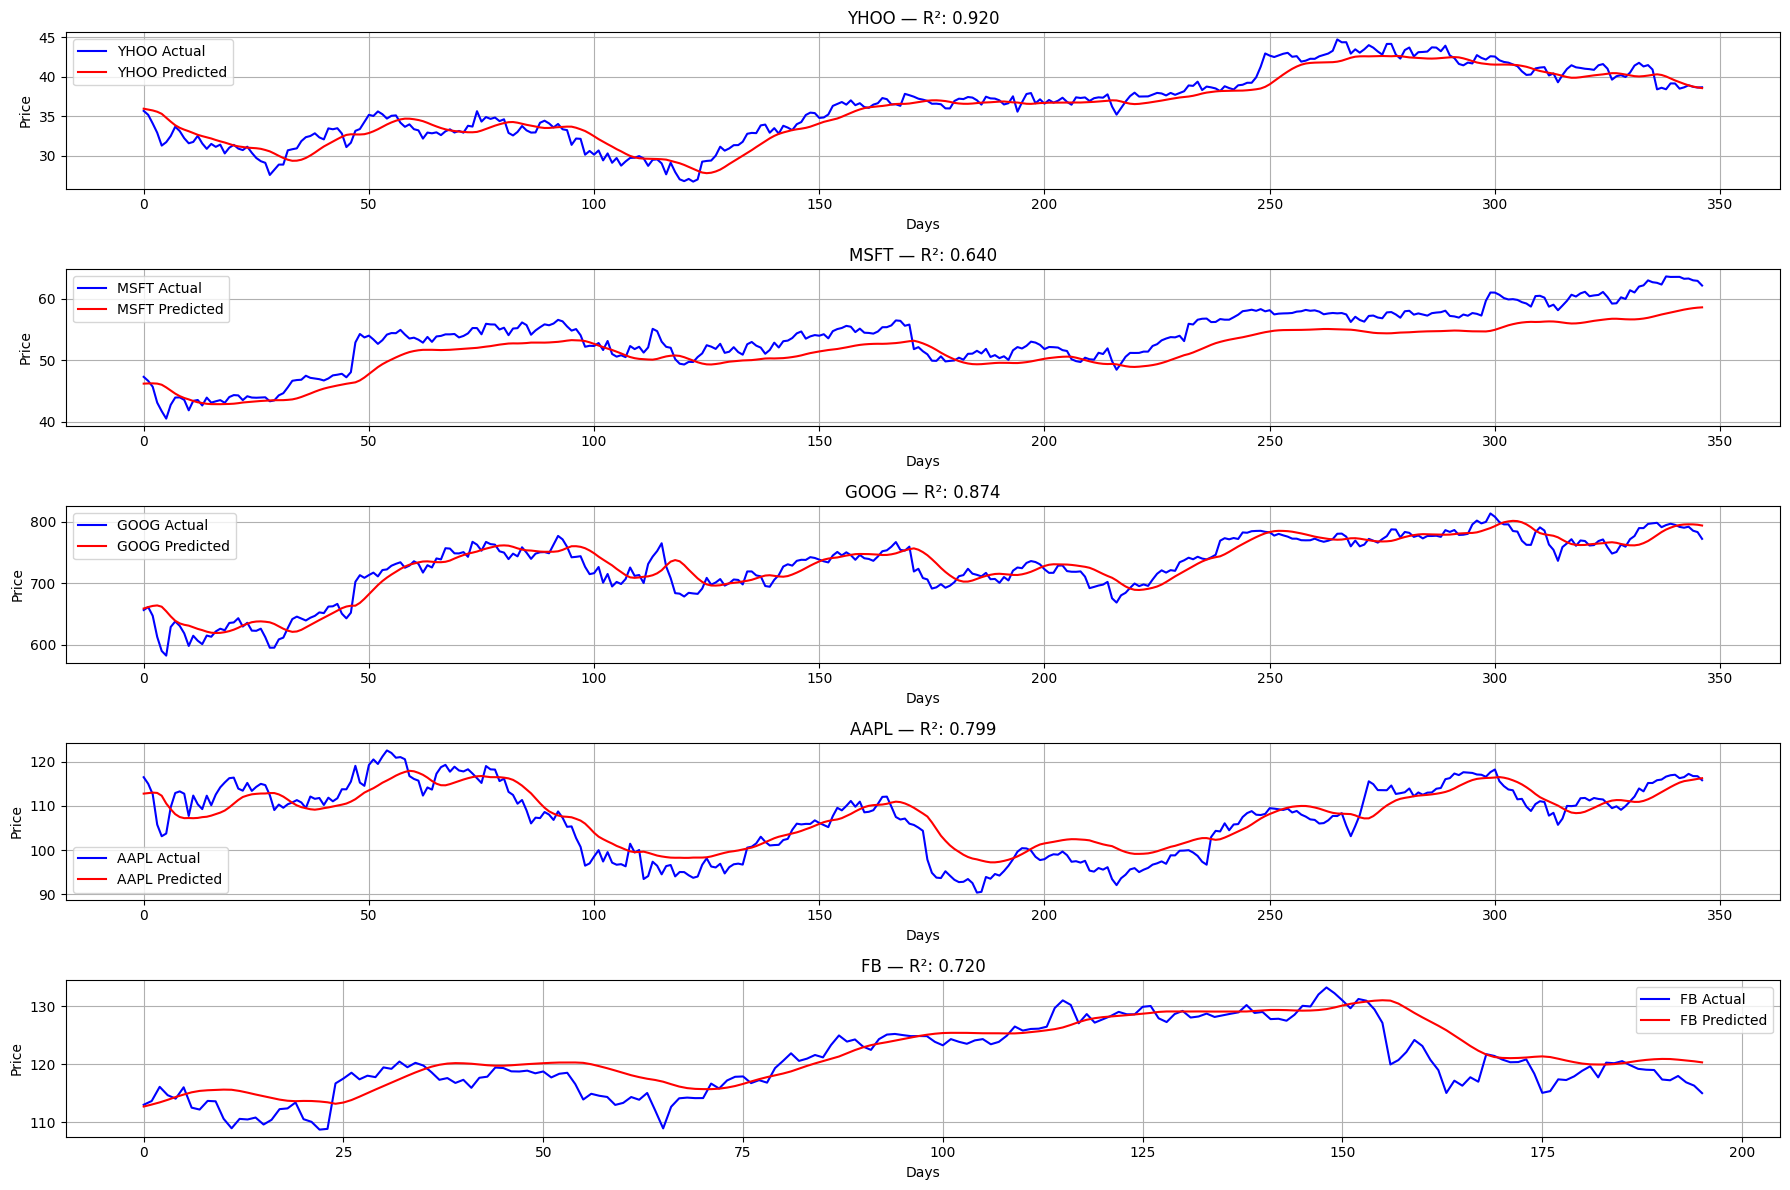

In [40]:
plt.figure(figsize=(18, 12))
for i, symbol in enumerate(selected_companies):
    plt.subplot(len(selected_companies), 1, i+1)
    plt.plot(results[symbol]["actual"], label=f"{symbol} Actual", color='blue')
    plt.plot(results[symbol]["predicted"], label=f"{symbol} Predicted", color='red')
    plt.title(f"{symbol} — R²: {results[symbol]['r2']:.3f}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
final_report = pd.DataFrame({
    "Company": selected_companies,
    "R2 Score": [round(results[sym]["r2"], 4) for sym in selected_companies]
})

print("📋 Model Performance Summary:")
display(final_report)

📋 Model Performance Summary:


,Company,R2 Score
0,YHOO,0.9203
1,MSFT,0.6396
2,GOOG,0.8741
3,AAPL,0.7993
4,FB,0.7199
